## Notebook setup

In [11]:
import os
import io
import warnings
import datetime
import numpy as np
import base64
import pytz
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from IPython.display import HTML

# import sys
# sys.path.append('../../')

from openbb_terminal.api import widgets
from openbb_terminal.api import keys
from openbb_terminal.api import helper
from openbb_terminal.api import openbb
from openbb_terminal.helper_classes import TerminalStyle

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

### Header

In [12]:
try:
    theme = TerminalStyle("light", "light", "light")
except:
    pass
stylesheet = widgets.html_report_stylesheet()
with open("OpenBB_reports_logo.png", "rb") as image_file:
    openbb_image_encoded = base64.b64encode(image_file.read())

user_time_zone = pytz.timezone(helper.get_user_timezone())

In [13]:
author = "Diogo Sousa"
report_title = f"Global economy report"
report_date = pd.Timestamp.now(tz=user_time_zone).strftime("%d %B, %Y")
report_time = pd.Timestamp.now(tz=user_time_zone).strftime("%H:%M")
report_timezone = pd.Timestamp.now(tz=user_time_zone).astimezone().tzinfo
report_name = "economy_test"
report_title, report_date, report_time, report_timezone

('Global economy report',
 '29 August, 2022',
 '12:47',
 datetime.timezone(datetime.timedelta(seconds=3600), 'GMT Daylight Time'))

## Data

Overview

In [14]:
overview = openbb.economy.overview()
futures = openbb.economy.futures()
news = openbb.common.news("economy")

Events

In [15]:
us_week, us_title = openbb.economy.events(country="United states", start_date=datetime.datetime.now().strftime("%Y-%m-%d"), importance="high")

ez_week, ez_title = openbb.economy.events(country="Euro zone", start_date=datetime.datetime.now().strftime("%Y-%m-%d"), importance="all")
ez_week = ez_week[(ez_week["Importance"]=="High") | (ez_week["Importance"]=="Medium")]

cn_week, cn_title = openbb.economy.events(country="China", start_date=datetime.datetime.now().strftime("%Y-%m-%d"), importance="all")
cn_week

,Date,Time,Currency,Importance,Event,Actual,Forecast,Previous
0,2022-08-31,02:30,CNY,Medium,Chinese Composite PMI (Aug),,52.3,52.5
1,2022-08-31,02:30,CNY,High,Manufacturing PMI (Aug),,49.2,49.0
2,2022-08-31,02:30,CNY,Medium,Non-Manufacturing PMI (Aug),,,53.8
3,2022-09-01,02:45,CNY,High,Caixin Manufacturing PMI (Aug),,50.2,50.4
4,2022-09-05,02:45,CNY,Medium,Caixin Services PMI (Aug),,,55.5


Yields

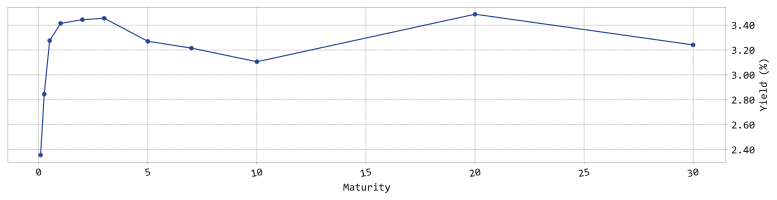

In [16]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.economy.ycrv(country="United states", external_axes=[ax], chart=True)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ycrv_chart = f.getvalue().decode("utf-8")
ycrv_data = openbb.economy.ycrv(country="United states")

Sectors

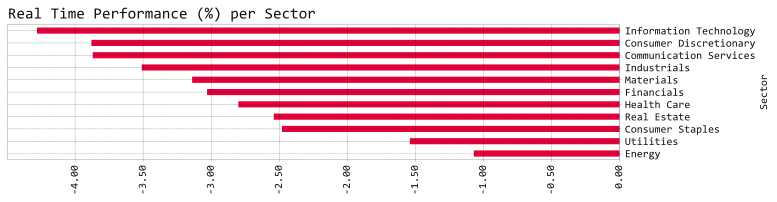

In [17]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.economy.rtps(external_axes=[ax], chart=True)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
rtps_chart = f.getvalue().decode("utf-8")
rtps_data = openbb.economy.rtps()

## Render the report template to a file

In [18]:
body = ""

img = f'<img src="data:image/png;base64,{openbb_image_encoded.decode()}" alt="OpenBB" style="width:144px;">'
body += widgets.header(
    img,
    author,
    report_date,
    report_time,
    report_timezone,
    f"<b>GLOBAL ECONOMY REPORT:</b>",
)

body += widgets.tablinks(
    [
        "Overview",
        "Events",
        "Yields",
        "Sectors",
    ]
)

# Overview
htmlcode = widgets.row([widgets.h(3, "Global markets") + overview.to_html()])
htmlcode += widgets.row([widgets.h(3, "Commodities") + futures.to_html()])
htmlcode += widgets.row([widgets.h(3, "Top news") + news[:6].to_html()])
body += widgets.add_tab("Overview", htmlcode)

# Events
htmlcode = widgets.row([widgets.h(3, us_title) + us_week.to_html()])
htmlcode += widgets.row([widgets.h(3, ez_title) + ez_week.to_html()])
htmlcode += widgets.row([widgets.h(3, cn_title) + cn_week.to_html()])
body += widgets.add_tab("Events", htmlcode)

# Yields
htmlcode = widgets.row([widgets.h(3, "US Yield curve") + ycrv_chart])
htmlcode += widgets.row([widgets.h(3, "") + ycrv_data.to_html()])
body += widgets.add_tab("Yields", htmlcode)

# Sectors
htmlcode = widgets.row([widgets.h(3, "Real-time sector performance") + rtps_chart])
htmlcode += widgets.row([widgets.h(3, "") + rtps_data.to_html()])
body += widgets.add_tab("Sectors", htmlcode)

body += widgets.tab_clickable_evt()
report = widgets.html_report(title=report_name, stylesheet=stylesheet, body=body)

# to save the results
with open(report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)